In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

## global variables

In [81]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather.csv'

time_step = 24
input_shape = 5
evaluation_results = []

# model specification
neurons = 250
epochs = 15
batch_size = 64

## helper functions

In [ ]:
# Modified evaluate_model function to store results in evaluation_results



def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, input_shape))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  save_path = os.path.join('./assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.close()

## Base BiLSTM

In [83]:
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

data = data[(data.index.month.isin([5, 6, 7])) & (data.index.year == 2021)]

# data = data[(data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# Set time_step (lookback window for BiLSTM)
time_step = 24  # Predict based on past 24 hours (1 day)
X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_78659/2107908898.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


dataset shape (8832, 5)
X, y shape (8808, 24, 5) (8808,)


In [84]:
print("Training BiLSTM only...")
print("\n")

model = build_bilstm_model(time_step)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

y_train_predict = scaler.inverse_transform(
    np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_predict = scaler.inverse_transform(
    np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

evaluate_model(y_train_actual, y_train_predict, 'BiLSTM', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'BiLSTM', 'Testing')

Training BiLSTM only...


Epoch 1/15
111/111 [==============================] - 14s 109ms/step - loss: 0.0125 - val_loss: 0.0073
Epoch 2/15
111/111 [==============================] - 12s 112ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 3/15
111/111 [==============================] - 14s 123ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 4/15
111/111 [==============================] - 13s 113ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 5/15
111/111 [==============================] - 14s 128ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 6/15
111/111 [==============================] - 13s 115ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 7/15
111/111 [==============================] - 13s 116ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 8/15
111/111 [==============================] - 14s 124ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 9/15
111/111 [==============================] - 13s 120ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 10/15
111/111 [==========================

In [85]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,168.051269,110008.000288,331.674540,0.919801
1,BiLSTM,Testing,177.401104,117942.086001,343.426973,0.903085


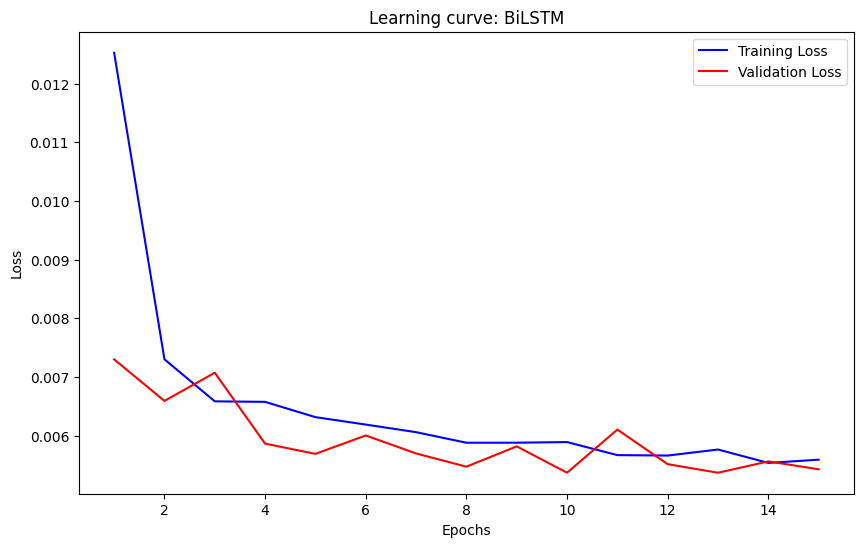

In [86]:
plot_learning_curve(history, 'BiLSTM')

## GBDT-BiLSTM

In [87]:
# Load and split data
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

data = data[(data.index.month.isin([5, 6, 7])) & (data.index.year == 2021)]

# data = data[(data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]

X = dataset.iloc[:, 1:].values  # Features
y = dataset.iloc[:, 0].values   # Target

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]




/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_78659/3576507457.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


In [88]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_train)
gbdt_output_test = gbdt.predict(X_test)

In [89]:
# Evaluate model performance on training and test sets
evaluate_model(y_train, gbdt_output_train, 'GBDT', 'Training')
evaluate_model(y_test, gbdt_output_test, 'GBDT', 'Testing')

In [90]:


# Step 3: Scale the model outputs
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train.reshape(-1, 1))
gbdt_output_test_scaled = scaler.transform(gbdt_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_gbdt, y_train_bilstm_gbdt = create_dataset(gbdt_output_train_scaled, time_step)
X_test_bilstm_gbdt, y_test_bilstm_gbdt = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_gbdt = X_train_bilstm_gbdt.reshape(X_train_bilstm_gbdt.shape[0], time_step, 1)
X_test_bilstm_gbdt = X_test_bilstm_gbdt.reshape(X_test_bilstm_gbdt.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_gbdt = model.fit(X_train_bilstm_gbdt, y_train_bilstm_gbdt, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_gbdt, y_test_bilstm_gbdt), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_gbdt_scaled = model.predict(X_test_bilstm_gbdt)

y_pred_bilstm_gbdt = scaler.inverse_transform(y_pred_bilstm_gbdt_scaled)
y_test_bilstm_gbdt_actual_rescaled = scaler.inverse_transform(y_test_bilstm_gbdt.reshape(-1, 1))

evaluate_model(y_test_bilstm_gbdt_actual_rescaled, y_pred_bilstm_gbdt, 'BiLSTM (GBDT)', 'Testing')

dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/15
111/111 [==============================] - 15s 121ms/step - loss: 0.0169 - val_loss: 0.0064
Epoch 2/15
111/111 [==============================] - 12s 111ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 3/15
111/111 [==============================] - 13s 114ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 4/15
111/111 [==============================] - 13s 115ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/15
111/111 [==============================] - 13s 117ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 6/15
111/111 [==============================] - 14s 122ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 7/15
111/111 [==============================] - 14s 124ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/15
111/111 [==============================] - 13s 121ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/15
111/111 [==============================] - 14s 127ms/step - loss: 0.0043 - val_l

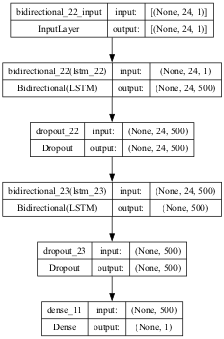

In [91]:
# Plotting the model architecture

plot_model(model, to_file='bilstm_gbdt.png', show_shapes=True, show_layer_names=True, dpi=50)


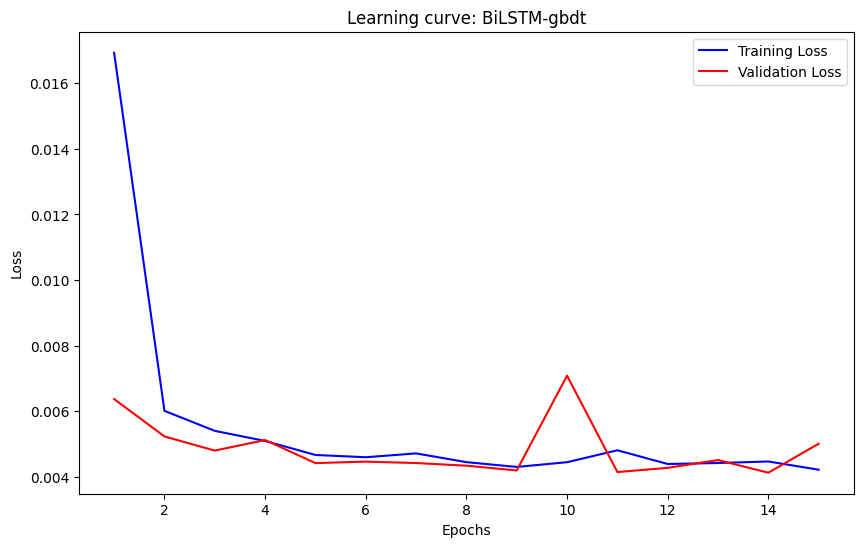

In [92]:
plot_learning_curve(history_gbdt, 'BiLSTM-gbdt')

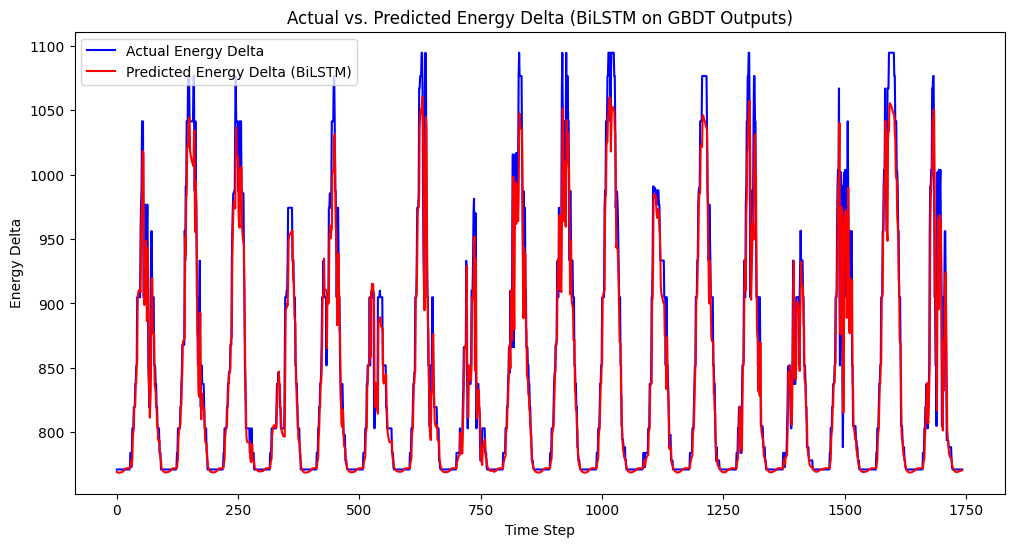

In [93]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_gbdt_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_gbdt, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on GBDT Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [94]:

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data

xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
xgb_output_train = xgb.predict(X_train)
xgb_output_test = xgb.predict(X_test)

evaluate_model(y_train, xgb_output_train, 'XGB', 'Training')
evaluate_model(y_test, xgb_output_test, 'XGB', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

xgb_output_train_scaled = scaler.fit_transform(xgb_output_train.reshape(-1, 1))
xgb_output_test_scaled = scaler.transform(xgb_output_test.reshape(-1, 1))


# Create BiLSTM input for all three model outputs

X_train_bilstm_xgb, y_train_bilstm_xgb = create_dataset(xgb_output_train_scaled, time_step)
X_test_bilstm_xgb, y_test_bilstm_xgb = create_dataset(xgb_output_test_scaled, time_step)

X_train_bilstm_xgb = X_train_bilstm_xgb.reshape(X_train_bilstm_xgb.shape[0], time_step, 1)
X_test_bilstm_xgb = X_test_bilstm_xgb.reshape(X_test_bilstm_xgb.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs

print("Training BiLSTM on XGB outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_xgb = model.fit(X_train_bilstm_xgb, y_train_bilstm_xgb, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_xgb, y_test_bilstm_xgb), verbose=1)

# Step 7: Predict with BiLSTM

y_pred_bilstm_xgb_scaled = model.predict(X_test_bilstm_xgb)
y_pred_bilstm_xgb = scaler.inverse_transform(y_pred_bilstm_xgb_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_xgb_actual_rescaled = scaler.inverse_transform(y_test_bilstm_xgb.reshape(-1, 1))

evaluate_model(y_test_bilstm_xgb_actual_rescaled, y_pred_bilstm_xgb, 'BiLSTM (XGB)', 'Testing')

dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on XGB outputs...


Epoch 1/15
111/111 [==============================] - 12s 99ms/step - loss: 0.0152 - val_loss: 0.0062
Epoch 2/15
111/111 [==============================] - 12s 110ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 3/15
111/111 [==============================] - 12s 112ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 4/15
111/111 [==============================] - 13s 117ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 5/15
111/111 [==============================] - 14s 124ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 6/15
111/111 [==============================] - 14s 123ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 7/15
111/111 [==============================] - 13s 114ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 8/15
111/111 [==============================] - 13s 119ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/15
111/111 [==============================] - 12s 110ms/step - loss: 0.0044 - val_los

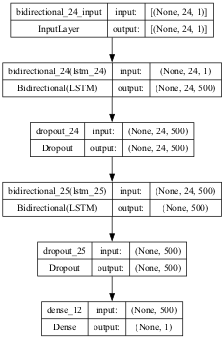

In [95]:
# Plotting the model architecture
plot_model(model, to_file='bilstm_xgb.png', show_shapes=True, show_layer_names=True, dpi=50)

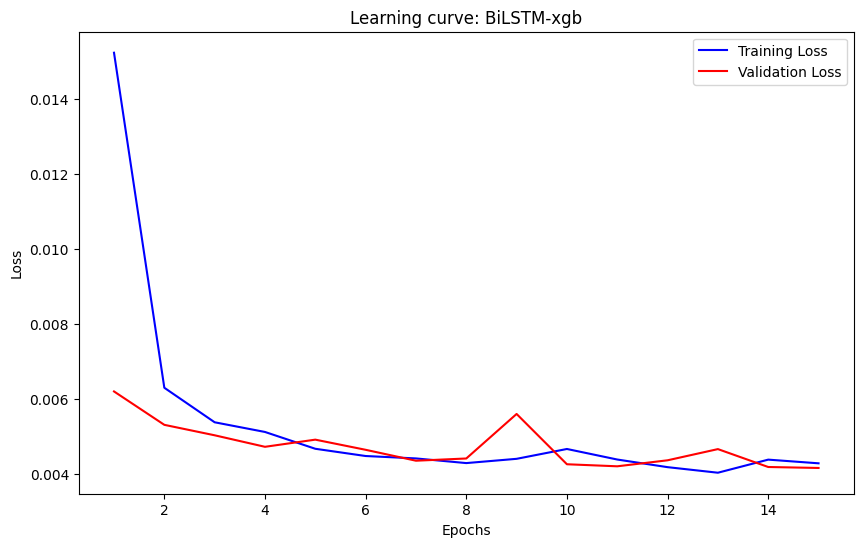

In [96]:
plot_learning_curve(history_xgb, 'BiLSTM-xgb')

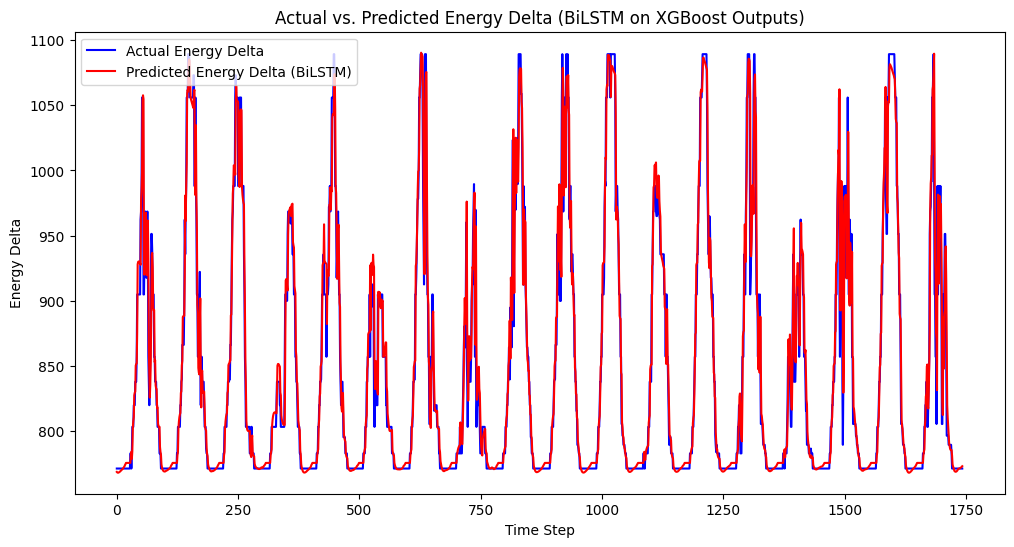

In [97]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_xgb_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_xgb, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on XGBoost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [98]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5)

catboost.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
catboost_output_train = catboost.predict(X_train)
catboost_output_test = catboost.predict(X_test)

# Evaluate model performance on training and test sets 
evaluate_model(y_train, catboost_output_train, 'Catboost', 'Training')
evaluate_model(y_test, catboost_output_test, 'Catboost', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

catboost_output_train_scaled = scaler.fit_transform(catboost_output_train.reshape(-1, 1))
catboost_output_test_scaled = scaler.transform(catboost_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_catboost, y_train_bilstm_catboost = create_dataset(catboost_output_train_scaled, time_step)
X_test_bilstm_catboost, y_test_bilstm_catboost = create_dataset(catboost_output_test_scaled, time_step)

X_train_bilstm_catboost = X_train_bilstm_catboost.reshape(X_train_bilstm_catboost.shape[0], time_step, 1)
X_test_bilstm_catboost = X_test_bilstm_catboost.reshape(X_test_bilstm_catboost.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on CatBoost outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_catboost = model.fit(X_train_bilstm_catboost, y_train_bilstm_catboost, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_catboost, y_test_bilstm_catboost), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_catboost_scaled = model.predict(X_test_bilstm_catboost)
y_pred_bilstm_catboost = scaler.inverse_transform(y_pred_bilstm_catboost_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_catboost_actual_rescaled = scaler.inverse_transform(y_test_bilstm_catboost.reshape(-1, 1))

evaluate_model(y_test_bilstm_catboost_actual_rescaled, y_pred_bilstm_catboost, 'BiLSTM (CatBoost)', 'Testing')

0:	learn: 1169.0946685	total: 4.97ms	remaining: 493ms
1:	learn: 1168.0925272	total: 6.04ms	remaining: 296ms
2:	learn: 1167.1084474	total: 6.95ms	remaining: 225ms
3:	learn: 1166.1101742	total: 7.63ms	remaining: 183ms
4:	learn: 1165.1298663	total: 8.39ms	remaining: 159ms
5:	learn: 1164.1408403	total: 8.94ms	remaining: 140ms
6:	learn: 1163.1617526	total: 9.57ms	remaining: 127ms
7:	learn: 1162.1639709	total: 10.2ms	remaining: 117ms
8:	learn: 1161.1852677	total: 10.7ms	remaining: 109ms
9:	learn: 1160.2169376	total: 11.3ms	remaining: 102ms
10:	learn: 1159.2356772	total: 11.9ms	remaining: 96.6ms
11:	learn: 1158.2490492	total: 12.5ms	remaining: 91.9ms
12:	learn: 1157.2513880	total: 13.1ms	remaining: 87.7ms
13:	learn: 1156.2673679	total: 13.7ms	remaining: 84.4ms
14:	learn: 1155.3003584	total: 14.3ms	remaining: 81.2ms
15:	learn: 1154.3299804	total: 15ms	remaining: 78.6ms
16:	learn: 1153.3389060	total: 15.6ms	remaining: 76.2ms
17:	learn: 1152.3799063	total: 16.2ms	remaining: 73.7ms
18:	learn: 115

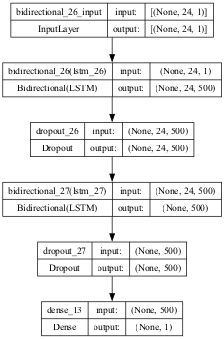

In [99]:
plot_model(model, to_file='bilstm_catboost.png', show_shapes=True, show_layer_names=True, dpi=50)


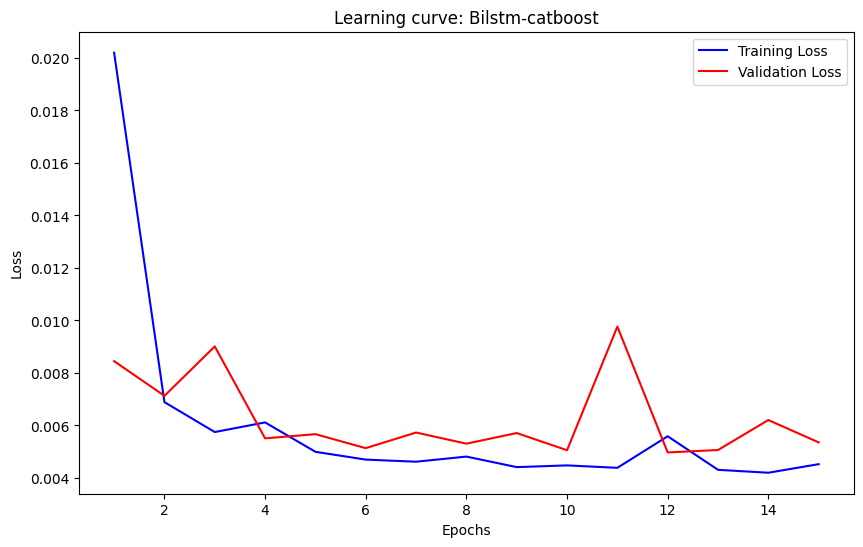

In [100]:
plot_learning_curve(history_catboost, 'Bilstm-catboost')

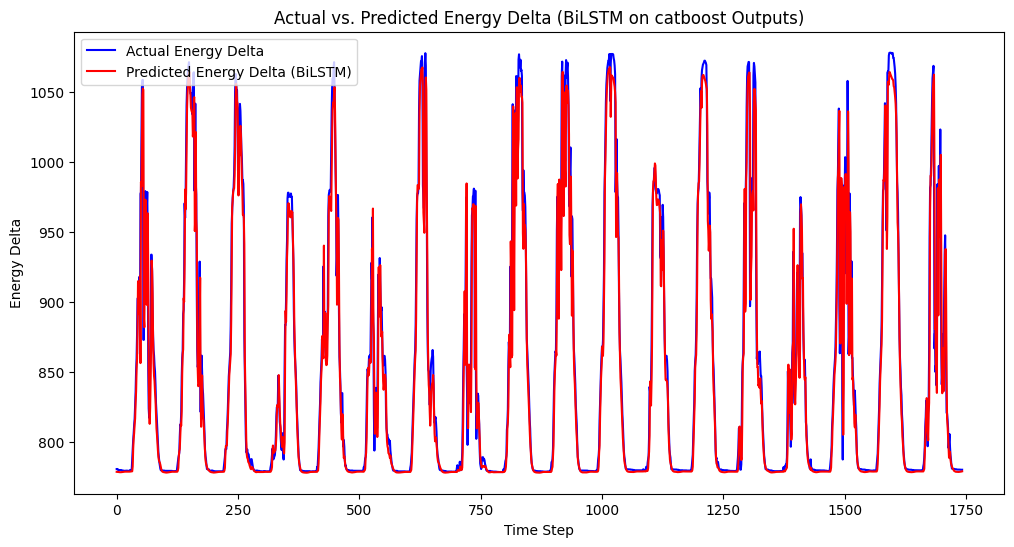

In [101]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_catboost_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_catboost, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on catboost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [102]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

lgbm.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
lgbm_output_train = lgbm.predict(X_train)
lgbm_output_test = lgbm.predict(X_test)


# Evaluate model performance on training and test sets
evaluate_model(y_train, lgbm_output_train, 'LightGBM', 'Training')
evaluate_model(y_test, lgbm_output_test, 'LightGBM', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
lgbm_output_train_scaled = scaler.fit_transform(lgbm_output_train.reshape(-1, 1))
lgbm_output_test_scaled = scaler.transform(lgbm_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_lgbm, y_train_bilstm_lgbm = create_dataset(lgbm_output_train_scaled, time_step)
X_test_bilstm_lgbm, y_test_bilstm_lgbm = create_dataset(lgbm_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_lgbm = X_train_bilstm_lgbm.reshape(X_train_bilstm_lgbm.shape[0], time_step, 1)
X_test_bilstm_lgbm = X_test_bilstm_lgbm.reshape(X_test_bilstm_lgbm.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_lgbm = model.fit(X_train_bilstm_lgbm, y_train_bilstm_lgbm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_lgbm, y_test_bilstm_lgbm), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_lgbm_scaled = model.predict(X_test_bilstm_lgbm)
y_pred_bilstm_lgbm = scaler.inverse_transform(y_pred_bilstm_lgbm_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_lgbm_actual_rescaled = scaler.inverse_transform(y_test_bilstm_lgbm.reshape(-1, 1))
evaluate_model(y_test_bilstm_lgbm_actual_rescaled, y_pred_bilstm_lgbm, 'BiLSTM (LightGBM)', 'Testing')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 7065, number of used features: 4
[LightGBM] [Info] Start training from score 852.045718
dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/15
111/111 [==============================] - 13s 95ms/step - loss: 0.0148 - val_loss: 0.0065
Epoch 2/15
111/111 [==============================] - 14s 130ms/step - loss: 0.0058 - val_loss: 0.0187
Epoch 3/15
111/111 [==============================] - 12s 109ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 4/15
111/111 [==============================] - 13s 117ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 5/15
111/111 [==============================] - 13s 119ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 6/15
111/111 [==============================] - 12s 11

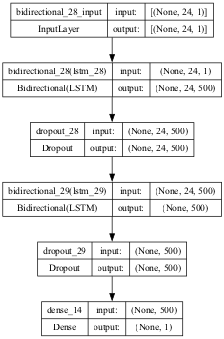

In [103]:
plot_model(model, to_file='bilstm_lightgbm.png', show_shapes=True, show_layer_names=True, dpi=50)

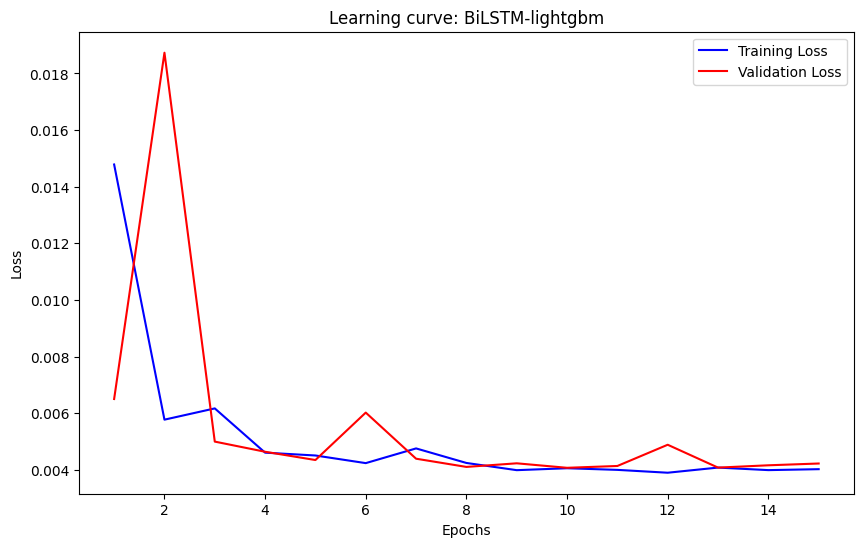

In [104]:
plot_learning_curve(history_lgbm, 'BiLSTM-lightgbm')

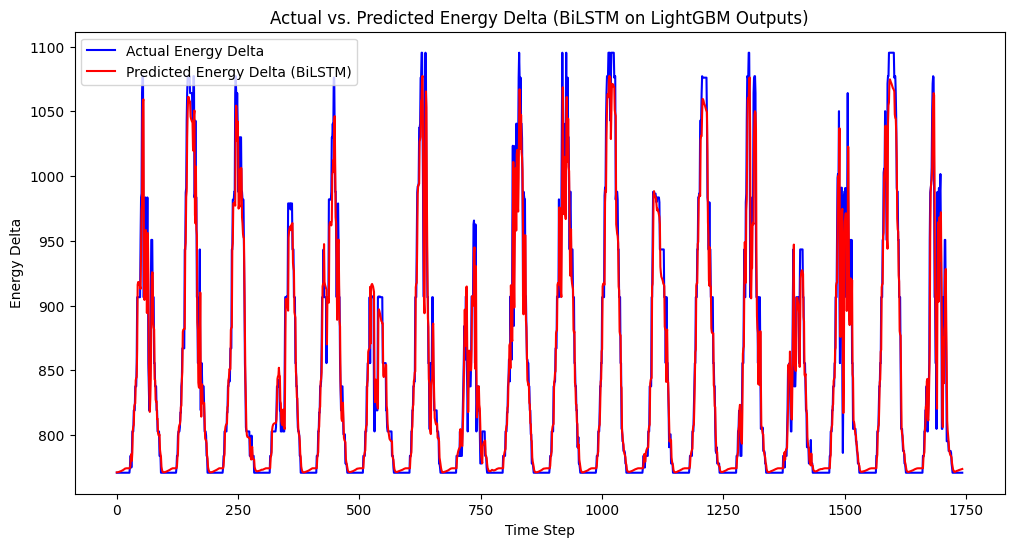

In [105]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_lgbm_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_lgbm, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on LightGBM Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [106]:
results_df = pd.DataFrame(evaluation_results)
print("\nevaluation metrics table: ")


evaluation metrics table: 


In [107]:
results_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,168.051269,1.100080e+05,331.674540,0.919801
1,BiLSTM,Testing,177.401104,1.179421e+05,343.426973,0.903085
2,GBDT,Training,860.401897,1.144981e+06,1070.037900,0.163687
3,GBDT,Testing,836.409249,1.030336e+06,1015.054721,0.153355
4,BiLSTM (GBDT),Testing,14.622573,6.569585e+02,25.631202,0.926260
5,XGB,Training,860.634503,1.146407e+06,1070.704047,0.162645
6,XGB,Testing,836.155556,1.028978e+06,1014.385500,0.154472
7,BiLSTM (XGB),Testing,12.730070,5.220790e+02,22.849049,0.942285
8,Catboost,Training,864.050374,1.157826e+06,1076.023293,0.154304
9,Catboost,Testing,838.195377,1.033128e+06,1016.428878,0.151062


In [108]:
from tensorflow.keras import backend as K
K.clear_session()
